In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
print(sys.version)

3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]


In [3]:
data = pd.read_csv(os.getcwd() + '\\data\\ACS_16_5YR_DP04_with_ann.csv', 
                   skiprows=1, sep=',', encoding='latin1', dtype='object')

### Data Cleaning

In [4]:
data.head()

,Id,Id2,Geography,Estimate; HOUSING OCCUPANCY - Total housing units,Margin of Error; HOUSING OCCUPANCY - Total housing units,Percent; HOUSING OCCUPANCY - Total housing units,Percent Margin of Error; HOUSING OCCUPANCY - Total housing units,Estimate; HOUSING OCCUPANCY - Total housing units - Occupied housing units,Margin of Error; HOUSING OCCUPANCY - Total housing units - Occupied housing units,Percent; HOUSING OCCUPANCY - Total housing units - Occupied housing units,...,Percent; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Occupied units paying rent (excluding units where GRAPI cannot be computed) - 30.0 to 34.9 percent,Percent Margin of Error; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Occupied units paying rent (excluding units where GRAPI cannot be computed) - 30.0 to 34.9 percent,Estimate; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Occupied units paying rent (excluding units where GRAPI cannot be computed) - 35.0 percent or more,Margin of Error; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Occupied units paying rent (excluding units where GRAPI cannot be computed) - 35.0 percent or more,Percent; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Occupied units paying rent (excluding units where GRAPI cannot be computed) - 35.0 percent or more,Percent Margin of Error; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Occupied units paying rent (excluding units where GRAPI cannot be computed) - 35.0 percent or more,Estimate; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Not computed,Margin of Error; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Not computed,Percent; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Not computed,Percent Margin of Error; GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - Not computed
0,0500000US01001,1001,"Autauga County, Alabama",22714,75,22714,(X),20800,391,91.6,...,9.5,4.8,2302,488,46.2,7.4,602,175,(X),(X)
1,0500000US01003,1003,"Baldwin County, Alabama",107579,202,107579,(X),75149,1285,69.9,...,9.5,1.7,7389,578,40.1,2.9,2840,449,(X),(X)
2,0500000US01005,1005,"Barbour County, Alabama",11802,101,11802,(X),9122,286,77.3,...,9.7,4.1,1128,187,42.3,5.3,626,149,(X),(X)
3,0500000US01007,1007,"Bibb County, Alabama",8972,76,8972,(X),7048,352,78.6,...,13,9.2,473,156,31,9.4,401,145,(X),(X)
4,0500000US01009,1009,"Blount County, Alabama",23850,59,23850,(X),20619,403,86.5,...,9.2,3.8,1096,216,33.8,5.4,1121,225,(X),(X)


In [5]:
df = data[['Geography',
       'Estimate; HOUSING OCCUPANCY - Total housing units',
       'Estimate; HOUSING OCCUPANCY - Total housing units - Occupied housing units',
       'Estimate; HOUSING OCCUPANCY - Total housing units - Vacant housing units']].copy()

In [6]:
df.columns = ['County','Total Units','Occupied Units','Vacant Units']

In [7]:
df['State'] = df['County'].str.split(', ', expand=True)[1] #grab state

In [8]:
df = df.drop('County', axis=1)\
.set_index('State').astype(int).reset_index()\
.groupby('State').sum() #sum across states

In [9]:
df['Vacancy Rate'] = df['Vacant Units'] / df['Total Units']
df['Occupancy Rate'] = df['Occupied Units'] / df['Total Units']

In [10]:
national_vacancy_rate = df['Vacant Units'].sum() / df['Total Units'].sum()
national_occupancy_rate = df['Occupied Units'].sum() / df['Total Units'].sum()

In [11]:
df['Vacancy'] = (df['Vacancy Rate'] / national_vacancy_rate) - 1 #compared to national average
df['Occupancy'] = (df['Occupancy Rate'] / national_occupancy_rate) - 1 #compared to national average

### Making Polar Plots

In [12]:
plot = df[df.index != 'District of Columbia'][['Vacancy','Occupancy']].copy()
plot = plot.sort_values(by='Vacancy', ascending=False) #sorted from largest to smallest vacancy rate

In [13]:
plot.head()

,Vacancy,Occupancy
State,,
Maine,0.986154,-0.136875
Vermont,0.749976,-0.104094
Florida,0.577298,-0.080127
Alaska,0.564041,-0.078287
Delaware,0.371810,-0.051606


In [14]:
def polar_lobes(a, b):
    #define angular ranges
    theta1 = np.arange(np.pi/2, 3*np.pi/2, 0.01)
    theta2 = np.arange(3*np.pi/2, 5*np.pi/2, 0.01)
    
    #define radial functions for lobes
    r1 = (1 + a)*np.cos(theta1)**2
    r2 = (1 + b)*np.cos(theta2)**2
    return (theta1, r1), (theta2, r2)

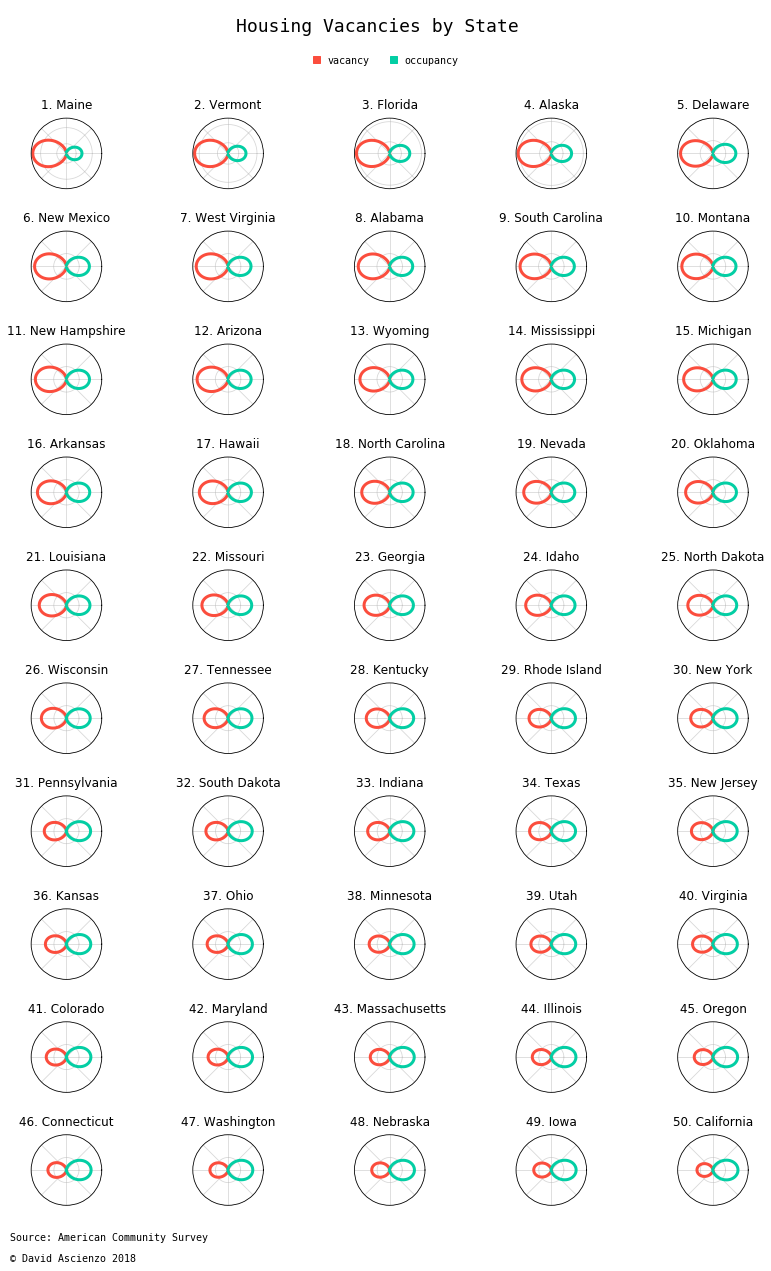

In [15]:
rows = plot.values #data rows

ncols = 5 #number of columns
nrows = int(len(rows)/ncols) #number of rows

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,20), subplot_kw={'polar':True})
plt.subplots_adjust(hspace=.6)

mpl.rcParams['font.family'] = 'monospace'

lwidth = 3.
color1 = '#FB4D3D'
color2 = '#03CEA4'

font_options = {'fontsize':12}

axs = axes.flatten()

#plot title
title = 'Housing Vacancies by State'
fname = os.getcwd() + '\\img\\' + '_'.join(title.split()) + '.png'
plt.suptitle(title, fontsize=18, y=.95)

#plot legend
vacancy_patch = mpatches.Patch(color=color1, label='vacancy')
occupancy_patch = mpatches.Patch(color=color2, label='occupancy')
plt.figlegend(ncol=2, loc=(0.4, .945), frameon=False, framealpha=1.,
              handles=[vacancy_patch,occupancy_patch], handlelength=.7)

#plots
for i, row in enumerate(rows):
    ax = axs[i]
    
    ax.set_title('{}. {}'.format(i+1,plot.index[i]), ha='center', **font_options)
    
    #polar plots
    vacancies, occupied = polar_lobes(row[0], row[1]) #get polar lobes
    ax.plot(vacancies[0], vacancies[1], color=color1, lw=lwidth, zorder=2) #percent of units with bad rent affordability
    ax.plot(occupied[0], occupied[1], color=color2, lw=lwidth, zorder=2) #percent of units with good rent affordability
    
    #set radial parameters
    ax.set_rmax(np.max(row) + 1.1)
    ax.set_rticks([.5,1.5])
    ax.set_yticklabels([])
    
    #label angular axis
    ax.set_xticks(np.arange(0,2*np.pi,np.pi/4))
    lab1 = '{:,.1f}%'.format(100*row[1])
    lab2 = '{:,.1f}%'.format(100*row[0])
    ax.set_xticklabels([''] + 3*[''] + [''], **font_options)
    ax.grid(True, alpha=.5)

#notes
plt.text(-.3,-.5,'Source: American Community Survey', fontsize=10, transform=axs[45].transAxes)
plt.text(-.3,-.8,'© David Ascienzo 2018', fontsize=10, transform=axs[45].transAxes)

#saving image file
plt.savefig(fname,
            format='png',
            dpi=300,
            bbox_inches='tight')

#show
plt.show()

In [16]:
#actual state rate comparisons to national averages
plot.multiply(100).round(2)

,Vacancy,Occupancy
State,,
Maine,98.62,-13.69
Vermont,75.00,-10.41
Florida,57.73,-8.01
Alaska,56.40,-7.83
Delaware,37.18,-5.16
New Mexico,34.79,-4.83
West Virginia,34.78,-4.83
Alabama,33.05,-4.59
South Carolina,32.13,-4.46
